In [28]:
# !pip install torch
# !pip install torchvision
# !pip install pandas
# !pip install matplotlib
# !pip install scipy
# !pip install scikit-learn

In [29]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import scipy
from torch.autograd import Variable

cudnn.benchmark = True
plt.ion()   # interactive mode

### Setting Seed

In [30]:
seed = 10
np.random.seed(seed)
torch.manual_seed(seed)

### Obtaining our datasets and dataloaders

In [31]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [32]:
device

device(type='cuda', index=0)

### Implementing a Custom Triplet dataset for Flowers 102

In [33]:
from pathlib import Path
from typing import Any, Tuple, Callable, Optional
import random
import PIL.Image

class NewFlowers(torchvision.datasets.flowers102.Flowers102):
  def __init__(
        self,
        root: str,
        split: str = "train",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
    ) -> None:
    super().__init__(root, split, transform, target_transform, download)
    self._labels = np.array(self._labels, dtype="int")
    
  def __getitem__(self, item):
    
    #obtain indexes of all the labels
    index = np.array(list(range(0, len(self._labels))), dtype="int")
    
    #obtain anchor image 
    anchor_img = self._image_files[item]
    anchor_img = PIL.Image.open(anchor_img).convert("RGB")
    
    #obtain anchor label
    anchor_label = self._labels[item]

    #generate positive index list where it is not the same class as the anchor
    positive_list = index[index!=item][self._labels[index!=item]==anchor_label]
    
    #randomly obtain 1 positive item and its respective image
    positive_item = random.choice(positive_list)
    positive_img = self._image_files[positive_item]
    positive_img = PIL.Image.open(positive_img).convert("RGB")

    #generate negative index list where it is not the same class as the anchor
    negative_list = index[index!=item][self._labels[index!=item]!=anchor_label]
    
    #randomly obtain 1 negative item and its respective image
    negative_item = random.choice(negative_list)
    negative_img = self._image_files[negative_item]
    negative_img = PIL.Image.open(negative_img).convert("RGB")

    #apply transformation on images
    anchor_img = self.transform(anchor_img)
    positive_img = self.transform(positive_img)
    negative_img = self.transform(negative_img)

    return (anchor_img, positive_img, negative_img), anchor_label

In [34]:
triplet_train = NewFlowers("./data/train", split="train", download=True, transform=data_transforms["train"])
triplet_val = NewFlowers("./data/train", split="val", download=True, transform=data_transforms["val"])
triplet_test = NewFlowers("./data/train", split="test", download=True, transform=data_transforms["test"])

In [35]:
triplet_train_dataloader = torch.utils.data.DataLoader(triplet_train, batch_size=4, shuffle=True)
triplet_val_dataloader = torch.utils.data.DataLoader(triplet_val, batch_size=4, shuffle=True)
triplet_test_dataloader = torch.utils.data.DataLoader(triplet_test, batch_size=4, shuffle=True)

In [36]:
image_datasets = {
    'train': triplet_train,
    'val': triplet_val,
    'test': triplet_test
}


dataloaders = {
    "train": triplet_train_dataloader,
    "val": triplet_val_dataloader,
    "test": triplet_test_dataloader,
}

dataset_sizes = {
        x: len(dataloaders[x].dataset)
        for x in list(image_datasets.keys())
    }

In [37]:
dataset_sizes

{'train': 1020, 'val': 1020, 'test': 6149}

### Function to visualise images

In [38]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

### Testing our triplet dataset

In [39]:
anchor, positive, negative = 0,0,0
for i, (inputs, labels) in enumerate(triplet_train_dataloader):
#     print(labels)
    anchor, positive, negative = inputs
    break

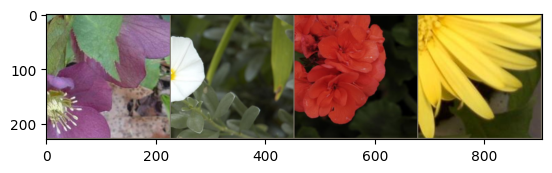

In [40]:
anchor_out = torchvision.utils.make_grid(anchor)
imshow(anchor_out)

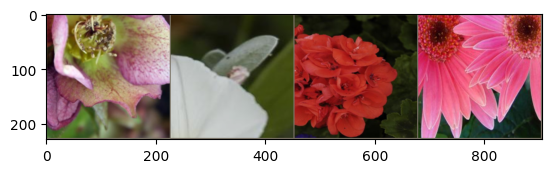

In [41]:
positive_out = torchvision.utils.make_grid(positive)
imshow(positive_out)

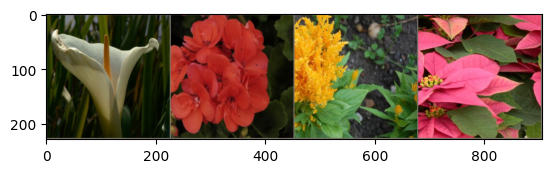

In [42]:
negative_out = torchvision.utils.make_grid(negative)
imshow(negative_out)

### General function to train the model (utilising both triplet loss & cross entropy loss)

In [43]:
def train_model(model, optimizer, criterion, scheduler, num_epochs=25):
    since = time.time()
    
    checkpoint_path = './model_checkpoints'
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
 
    best_model_params_path = os.path.join(checkpoint_path, 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    #this is to be used later
    crossEntropyLoss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for step, (inputs, anchor_label) in enumerate(dataloaders[phase]):

                anchor_label = anchor_label.to(device)
                
                anchor_img, positive_img, negative_img = inputs
                anchor_img = anchor_img.to(device)
                positive_img = positive_img.to(device)
                negative_img = negative_img.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    anchor_out = model(anchor_img)
                    positive_out = model(positive_img)
                    negative_out = model(negative_img)
                    
                    _, preds = torch.max(anchor_out, 1)

                    preds = preds.to(device)
                    
                    #this is from tripletLoss (class labels not involved in loss calculation)
                    loss = criterion(anchor_out, positive_out, negative_out) 

                    #in order to incorporate meaning to the loss, we experiment adding Cross Entropy Loss as class labels are involved in loss calculation
                    celoss = crossEntropyLoss(anchor_out, anchor_label)


                    loss += celoss

                    # print(anchor_out)
                    # print(f"anchor_out shape: {anchor_out.cpu().detach().numpy().shape}")
                    # print(f"anchor label: {anchor_label.data}")
                    # print(f"prediction: {preds}")
                    # print(f"torch.sum: {torch.sum(preds == anchor_label.data)}")
                    # print(loss)

                    # print(f"triplet loss:  {loss}")
                    # print(f"cross-entropy loss: {celoss}")
                    # print()

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * len(anchor_label)
                running_corrects += torch.sum(preds == anchor_label.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
            print(f'{phase} Loss:\t{epoch_loss:.4f}\tAcc:\t{epoch_acc:.4f}')

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            elif phase == 'val':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}\n')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, train_loss, train_acc, val_loss, val_acc

### Function to plot train & val accuracy/loss

In [44]:
def plot_graph(no_epoch, train, val, title):
    plt.figure()
    plt.plot(range(no_epoch), train, label='train')
    plt.plot(range(no_epoch), val, label='val')
    if "Accuracy" in title:
        plt.ylabel("Accuracy")
    elif "Loss" in title:
        plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

### Transfer learning with freezing (transformer vit_b_16)

In [45]:
model_path = './model_checkpoints/transformer_vit_b_16_freeze_TripletLoss_CrossEntropyLoss_GPU.pt'

check_file = os.path.exists(model_path)
if check_file:
    print(f"Loading model from checkpoint")
    loaded_transformer = torch.load(model_path)
    
else:
    print(f"Model checkpoint does not exist.\nDownloading new model...")
    model_conv = torchvision.models.vit_b_16(weights='IMAGENET1K_V1')
    
    #freezing all other layers
    for param in model_conv.parameters():
        param.requires_grad = False
        
    num_ftrs = model_conv.heads.head.in_features
    model_conv.heads.head = nn.Linear(num_ftrs, 102)

Model checkpoint does not exist.


In [46]:
print(model_conv)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [47]:
num_epochs = 40

model_conv = model_conv.to(device)

# Observe that only parameters of final layer are being optimized as opposed to before.
optimizer_conv = optim.SGD(model_conv.heads.head.parameters(), lr=0.001, momentum=0.9)

criterion = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.1)

In [48]:
model_conv, train_loss, train_acc, val_loss, val_acc = train_model(model_conv, optimizer_conv, criterion, exp_lr_scheduler, num_epochs=num_epochs)

Epoch 1/40
----------
train Loss:	4.4685	Acc:	0.1118
val Loss:	3.5029	Acc:	0.4157

Training complete in 1m 28s
Best val Acc: 0.415686

Epoch 2/40
----------
train Loss:	3.1358	Acc:	0.4931
val Loss:	2.5983	Acc:	0.6255

Training complete in 2m 37s
Best val Acc: 0.625490

Epoch 3/40
----------
train Loss:	2.3255	Acc:	0.6853
val Loss:	2.0918	Acc:	0.7069

Training complete in 3m 48s
Best val Acc: 0.706863

Epoch 4/40
----------
train Loss:	1.8292	Acc:	0.7980
val Loss:	1.7725	Acc:	0.7696

Training complete in 4m 57s
Best val Acc: 0.769608

Epoch 5/40
----------
train Loss:	1.4800	Acc:	0.8618
val Loss:	1.5234	Acc:	0.8118

Training complete in 6m 5s
Best val Acc: 0.811765

Epoch 6/40
----------
train Loss:	1.2600	Acc:	0.8765
val Loss:	1.4033	Acc:	0.8245

Training complete in 7m 14s
Best val Acc: 0.824510

Epoch 7/40
----------
train Loss:	1.0884	Acc:	0.9088
val Loss:	1.2474	Acc:	0.8245

Training complete in 8m 21s
Best val Acc: 0.824510

Epoch 8/40
----------
train Loss:	1.0848	Acc:	0.9039
val

### Saving model directly, instead of weights

In [49]:
torch.save(model_conv, model_path)

### Converting our train/val to lists of float values (currently tensors)

In [50]:
for i in range(num_epochs):
    train_acc[i] = train_acc[i].cpu()
    val_acc[i] = val_acc[i].cpu()

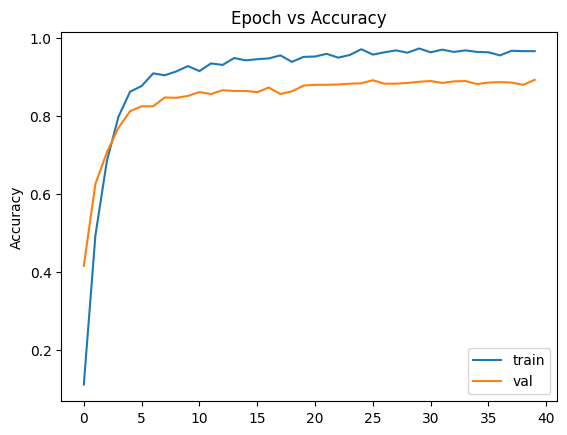

In [51]:
plot_graph(num_epochs, train_acc, val_acc, "Epoch vs Accuracy")

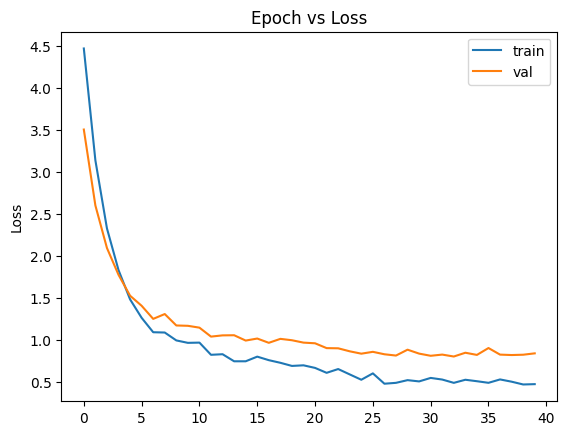

In [52]:
plot_graph(num_epochs, train_loss, val_loss, "Epoch vs Loss")

### Testing on test set

In [53]:
def test(model):
    was_training = model.training
    model.eval()
    # fig = plt.figure()
    size = len(dataloaders['test'].dataset)
    no_batches = len(dataloaders['test'])
    correct = 0
    with torch.no_grad():
        for i, (inputs, anchor_label) in enumerate(dataloaders['test']):

            anchor_label = anchor_label.to(device)
            
            anchor_img, _, _ = inputs
            anchor_img = anchor_img.to(device)
            
        
            anchor_out = model(anchor_img)

            _, preds = torch.max(anchor_out, 1)

            preds = preds.to(device)

            correct += torch.sum(preds == anchor_label.data)
            if i % 20 == 0:
                print(f'Predicted: {preds[0]} | True: {anchor_label[0]}')

    correct = correct.double() / size
    model.train(mode=was_training)
    return correct

In [54]:
test_acc = test(model_conv)

Predicted: 82 | True: 82
Predicted: 87 | True: 87
Predicted: 41 | True: 41
Predicted: 101 | True: 101
Predicted: 50 | True: 50
Predicted: 20 | True: 5
Predicted: 16 | True: 49
Predicted: 47 | True: 64
Predicted: 38 | True: 77
Predicted: 88 | True: 88
Predicted: 52 | True: 52
Predicted: 50 | True: 50
Predicted: 75 | True: 75
Predicted: 79 | True: 79
Predicted: 25 | True: 25
Predicted: 64 | True: 64
Predicted: 87 | True: 87
Predicted: 40 | True: 70
Predicted: 98 | True: 98
Predicted: 50 | True: 50
Predicted: 54 | True: 54
Predicted: 68 | True: 77
Predicted: 80 | True: 80
Predicted: 58 | True: 58
Predicted: 94 | True: 94
Predicted: 72 | True: 72
Predicted: 35 | True: 35
Predicted: 1 | True: 1
Predicted: 10 | True: 10
Predicted: 59 | True: 59
Predicted: 86 | True: 86
Predicted: 30 | True: 30
Predicted: 29 | True: 29
Predicted: 70 | True: 70
Predicted: 40 | True: 40
Predicted: 82 | True: 50
Predicted: 93 | True: 93
Predicted: 49 | True: 49
Predicted: 75 | True: 75
Predicted: 91 | True: 91
P

In [55]:
print(f"Test Acc: {test_acc}")

Test Acc: 0.8755895267523175
